In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [70]:
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [71]:
train_data['train'] = 1
test_data['train'] = 0
all_data = pd.concat([train_data,test_data])

In [72]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
trans = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [73]:
holiday['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

Looking to cleanup the additional data so it can be added to the original dataset. Ideally adding an oil price column, based on the day, and a Is Holiday column. Also looking to add a total transactions column for each store by day.

In [74]:
trans['store_nbr'].nunique()

54

In [75]:
train_data['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

It looks like transaction data does not include every store for each day

In [76]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

There are a couple missing oil values that need to be inputed. In this case I will use the previous day's oil price if the current day is null.

In [77]:
oil.fillna(method='ffill',inplace=True)

Since the first oil price is still missing we will go ahead and fill it with the second day's price.

In [78]:
oil.fillna(method='bfill',inplace=True)

In [79]:
oil.rename(columns={'dcoilwtico':'oil_price'},inplace=True)

In [80]:
all_data = all_data.merge(oil, on='date', how='left')

Next to work on cleaning up the holiday dataset

In [81]:
all_data = all_data.merge(stores, on='store_nbr', how='left')

We start by dropping days that were transferred as well as work days since those do not count as actual holidays

In [82]:
holiday.shape

(350, 6)

In [83]:
holiday['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [84]:
holiday = holiday[(holiday['type']!='Work Day') & (holiday['type']!='Transfer')]

In [85]:
holiday.shape

(333, 6)

We dropped 17 rows, which is the expected result, next we will split the holidays into regional and locale holidays

In [86]:
holiday['is_holiday'] = 1

In [87]:
region_hol = holiday[holiday['locale']=='Regional']
local_hol = holiday[holiday['locale']=='Local']
region_hol.rename(columns={'locale_name':'state'},inplace=True)
local_hol.rename(columns={'locale_name':'city'},inplace=True)

/tmp/ipykernel_32/2372454965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_hol.rename(columns={'locale_name':'state'},inplace=True)
/tmp/ipykernel_32/2372454965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_hol.rename(columns={'locale_name':'city'},inplace=True)


In [88]:
all_data = all_data.merge(region_hol[['date','state','is_holiday']], on=['date','state'], how='left')

In [89]:
all_data = all_data.merge(local_hol[['date','city','is_holiday']], on=['date','city'], how='left')

In [90]:
all_data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales             28512
onpromotion           0
train                 0
oil_price        864270
city                  0
state                 0
type                  0
cluster               0
is_holiday_x    3028377
is_holiday_y    3017190
dtype: int64

In [91]:
all_data.fillna({'is_holiday_x':0,'is_holiday_y':0},inplace=True)

In [92]:
all_data['is_holiday'] = all_data['is_holiday_x'] + all_data['is_holiday_y']

In [93]:
all_data['oil_price'] = all_data['oil_price'].fillna(method='ffill')
all_data.drop(['is_holiday_x','is_holiday_y'],axis=1,inplace=True)

In [94]:
all_data.head()

,id,date,store_nbr,family,sales,onpromotion,train,oil_price,city,state,type,cluster,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,93.14,Quito,Pichincha,D,13,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,1,93.14,Quito,Pichincha,D,13,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,1,93.14,Quito,Pichincha,D,13,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,93.14,Quito,Pichincha,D,13,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,1,93.14,Quito,Pichincha,D,13,0.0


Next to include is possibly the impact of payday (15th and last day of the month)  8-31-17 to 01-01-13

In [95]:
paydays = []
for year in ['2013','2014','2015','2016','2017']:
    for month, day in {'01':'31','02':'28','03':'31','04':'30','05':'31','06':'30','07':'31','08':'31','09':'30','10':'31','11':'30','12':'31'}.items():
        paydays.append(year+'-'+month+'-15')
        paydays.append(year+'-'+month+'-'+day)

In [96]:
del paydays[-8:]
paydays.append('2016-02-29')
paydays.remove('2016-02-28')

In [97]:
all_data['is_payday'] = all_data['date'].apply(lambda x: 1 if x in paydays else 0)

In [98]:
all_data[all_data['train']==1].groupby('type')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
A,500148.0,705.878743,1892.700760,0.0,0.0,24.0,468.00000,76090.000
B,444576.0,326.739714,977.528999,0.0,0.0,7.0,184.00000,89576.360
C,833580.0,197.263301,581.310901,0.0,0.0,5.0,121.38725,45361.000
D,1000296.0,350.979407,965.728732,0.0,0.0,16.0,224.21000,124717.000
E,222288.0,269.121301,761.422519,0.0,0.0,4.0,160.00000,16542.902


In [99]:
all_data['family'].nunique()

33

The type of store doesn't seem all the relevant and certain types seem to have large outliers. The city and state columns can be dropped in favor of using the store number instead.

The next step is to explore the cluster column to possibly create categorial groupings based on amount of competition.

In [100]:
all_data['cluster'].value_counts()

cluster
3     392700
10    336600
6     336600
15    280500
13    224400
14    224400
11    168300
4     168300
8     168300
1     168300
9     112200
2     112200
7     112200
16     56100
5      56100
12     56100
17     56100
Name: count, dtype: int64

It seems cluster size in the dataset varies between 1-17 nearby stores. I'll split this into low competition(1-5 stores), medium competition (6-11 stores) and high competition (12+ stores)

In [101]:
all_data['competition'] = all_data['cluster'].apply(lambda x: 1 if x <6 else(2 if 5<x<12 else 3))

All that remains is to clear out the unnecessary columns, encode the family and store id columns and potentially normalize the oil price and promotional data

<Axes: ylabel='Frequency'>

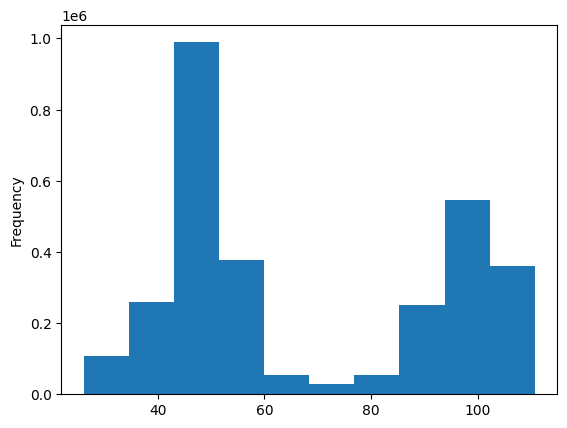

In [102]:
all_data['oil_price'].plot(kind='hist')

In [103]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train = all_data[all_data['train']==1]
test = all_data[all_data['train']==0]

train[['onpromotion','oil_price']] = scaler.fit_transform(train[['onpromotion','oil_price']])
test[['onpromotion','oil_price']] = scaler.transform(test[['onpromotion','oil_price']])

all_data = pd.concat([train,test])

/tmp/ipykernel_32/833961772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['onpromotion','oil_price']] = scaler.fit_transform(train[['onpromotion','oil_price']])
/tmp/ipykernel_32/833961772.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['onpromotion','oil_price']] = scaler.transform(test[['onpromotion','oil_price']])


In [104]:
all_data.head()

,id,date,store_nbr,family,sales,onpromotion,train,oil_price,city,state,type,cluster,is_holiday,is_payday,competition
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,1,0.792965,Quito,Pichincha,D,13,0.0,0,3
1,1,2013-01-01,1,BABY CARE,0.0,0.0,1,0.792965,Quito,Pichincha,D,13,0.0,0,3
2,2,2013-01-01,1,BEAUTY,0.0,0.0,1,0.792965,Quito,Pichincha,D,13,0.0,0,3
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,1,0.792965,Quito,Pichincha,D,13,0.0,0,3
4,4,2013-01-01,1,BOOKS,0.0,0.0,1,0.792965,Quito,Pichincha,D,13,0.0,0,3


In [105]:
all_data['store_nbr'] = all_data['store_nbr'].astype('str')

**Model**

In [106]:
X = all_data[all_data['train']==1].drop(['id','date','sales','train','city','state','cluster'],axis=1)
y = all_data[all_data['train']==1]['sales']
testing_data = all_data[all_data['train']==0].drop(['id','date','sales','train','city','state','cluster'],axis=1)

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Input, Reshape, Concatenate, BatchNormalization
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf

In [108]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

**Nerual Net**

In [109]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400710 entries, 2826741 to 1027277
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    object 
 1   family       object 
 2   onpromotion  float64
 3   oil_price    float64
 4   type         object 
 5   is_holiday   float64
 6   is_payday    int64  
 7   competition  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 164.8+ MB


In [110]:
for col in ['store_nbr','family','type']:
    print(X[col].nunique())

54
33
5


In [111]:
def prepare_data(df):
    cat_feats = df.select_dtypes('object').columns
    num_feats = df.select_dtypes('number').columns
    for col in cat_feats:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
    return df,cat_feats,num_feats

In [112]:
X_train_rdy, cat_col, num_col = prepare_data(X_train)
models = []
inputs = []
for cat in cat_col:
    vocab_size = X_train_rdy[cat].nunique()
    target_size = round(np.sqrt(vocab_size))
    inpt = Input(shape=(1,),name='input_'+cat)
    embed = Embedding(vocab_size, target_size, trainable=True)(inpt)
    embed_reshape = Reshape(target_shape=(target_size,))(embed)
    models.append(embed_reshape)
    inputs.append(inpt)

num_input = Input(shape=(len(num_col)),name='input_numeric_feats')
models.append(num_input)
inputs.append(num_input)

merge_models = tf.keras.layers.concatenate(models)

In [113]:
pre_preds = Dense(200)(merge_models)
pre_preds = BatchNormalization()(pre_preds)
pre_preds = Dense(200)(pre_preds)
pre_preds = BatchNormalization()(pre_preds)
pred = Dense(1, activation='relu')(pre_preds)
model_full = Model(inputs=inputs, outputs=pred)
model_full.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(),optimizer='adam')

In [114]:
input_dict= {
    'input_store_nbr':X_train_rdy["store_nbr"],
    "input_family":X_train_rdy["family"],
    "input_type":X_train_rdy['type'],
    "input_numeric_feats": X_train_rdy[num_col]
}

In [115]:
model_full.fit(input_dict,y_train,epochs=35,batch_size=64)

Epoch 1/35
37512/37512 [==============================] - 172s 5ms/step - loss: 2.3933
Epoch 2/35
37512/37512 [==============================] - 165s 4ms/step - loss: 2.2509
Epoch 3/35
37512/37512 [==============================] - 167s 4ms/step - loss: 2.2222
Epoch 4/35
37512/37512 [==============================] - 166s 4ms/step - loss: 2.2043
Epoch 5/35
37512/37512 [==============================] - 165s 4ms/step - loss: 2.1934
Epoch 6/35
37512/37512 [==============================] - 173s 5ms/step - loss: 2.1829
Epoch 7/35
37512/37512 [==============================] - 171s 5ms/step - loss: 2.1691
Epoch 8/35
37512/37512 [==============================] - 171s 5ms/step - loss: 2.1621
Epoch 9/35
37512/37512 [==============================] - 172s 5ms/step - loss: 2.1501
Epoch 10/35
37512/37512 [==============================] - 166s 4ms/step - loss: 2.1391
Epoch 11/35
37512/37512 [==============================] - 166s 4ms/step - loss: 2.1321
Epoch 12/35
37512/37512 [================

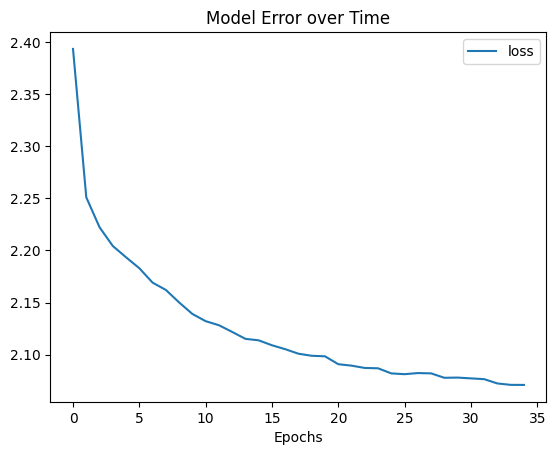

In [116]:
pd.DataFrame(model_full.history.history).plot()
plt.xlabel('Epochs')
plt.title('Model Error over Time')
plt.show()

In [117]:
X_test_rdy, cat_cols, num_cols = prepare_data(X_test)
input_dict_test= {
    'input_store_nbr':X_test_rdy["store_nbr"],
    "input_family":X_test_rdy["family"],
    "input_type":X_test_rdy['type'],
    "input_numeric_feats": X_test_rdy[num_col]
}

preds = model_full.predict(input_dict_test)

18756/18756 [==============================] - 36s 2ms/step


In [118]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(y_test, preds)

print(f'Mean Squared Logarithmic Error: {msle:.4f}')


Mean Squared Logarithmic Error: 2.0419


In [121]:
sales = np.exp(msle) - 1
print(f'Error in terms of numbers of sales: {sales:.2f}')

Error in terms of numbers of sales: 6.71


In [122]:
model_full.save('store_sales_model.h5')

In [123]:
from IPython.display import FileLink
FileLink(r'store_sales_model.h5')

/kaggle/working/store_sales_model.h5

### Submission

In [124]:
testing_data_rdy, cat_cols, num_cols = prepare_data(testing_data)
input_dict_test= {
    'input_store_nbr':testing_data_rdy["store_nbr"],
    "input_family":testing_data_rdy["family"],
    "input_type":testing_data_rdy['type'],
    "input_numeric_feats": testing_data_rdy[num_col]
}

predictions = model_full.predict(input_dict_test)

891/891 [==============================] - 2s 2ms/step


In [127]:
test['sales'] = predictions

In [137]:
submission = test[['id','sales']]
submission.to_csv('submission.csv',header=True,index=False)